# Noisy quantum evolution with Rydberg atoms


Noise is ubiquitous in quantum computers which affects the accuracy of the calculations they perform. Various sources could contribute to the noise in a quantum computer, including cosmic rays, disturbances caused by an approaching train, or even the ambient light of the room where the quantum computer sits. These sources of error could affect qubit lifetimes, gate fidelities, and the reliability of preparation and measurement. In previous notebooks, we have introduced [the noise models on Amazon Braket](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Amazon_Braket.ipynb) and [those on Rigetti](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Rigetti.ipynb), which focus on the noise models for gate-based devices. In this notebook, we will dive deep into several sources of noise for Rydberg devices, which have different underlying physics, and understand how they affect the analog Hamiltonian simulation (AHS) program running on these devices. In particular, we will use the coherent evolution of the Bell state of a pair Rydberg atoms under the AHS Hamiltonian to illustrate the effects of different noise sources."

## Creating and evolving a Bell state with Rydberg atoms

[Bell states](https://en.wikipedia.org/wiki/Bell_state) are a set of maximally entagled states of two qubits. Here, we consider creating and evolving a Bell state with Rydberg atoms in the presence of noise. We will see how noise affects the quality of the prepared Bell state and its quantum evolution. 

For a pair of atoms, their Rydberg Hamiltonian can be written as a $4\times4$ matrix in the basis of $\left\{|gg\rangle, |gr\rangle, |rg\rangle, |rr\rangle\right\}$
\begin{align}
H = 
\begin{bmatrix}
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & 0 \\
\frac{\Omega}{2} & -\Delta & 0 & \frac{\Omega}{2}\\
\frac{\Omega}{2} & 0 & -\Delta & \frac{\Omega}{2}\\
0 & \frac{\Omega}{2} & \frac{\Omega}{2} & V-2\Delta
\end{bmatrix}.
\end{align}
Here $\Omega$ and $\Delta$ are the amplitude and detuning of a time-varying global driving field, and $V\equiv C_6/R^6$ is the interaction strength between the two atoms which depends on their distance $R$ and a constant $C_6\equiv 5.42\times10^{-24} \text{ rad m}^6/\text{s}$. To create a Bell state, we consider putting the two atoms within the Rydberg blockade radius. As discussed in [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb), if both atoms are subject to zero detuning ($\Delta=0$), it is very unlikely to excite both atoms to the Rydberg states simultaneously and effectively there are only three states in the Hilbert space, namely $|gg\rangle$, $|gr\rangle$ and $|rg\rangle$. Suppose the two atoms are initilized in the ground state and the amplitude of the driving field, which has duration $T$, satisfies (we will refer to the following quantity as amplitude area below)
\begin{align}
\int_{0}^T\Omega(t)dt = \frac{\pi}{\sqrt{2}},
\end{align}
then one can show that the final state of the two atoms is a Bell state, i.e.,
\begin{align}
|\phi_1\rangle = \exp\left\{-i
\begin{bmatrix}
0 & \frac{\pi}{2\sqrt{2}} & \frac{\pi}{2\sqrt{2}}\\
\frac{\pi}{2\sqrt{2}} & 0 & 0 \\
\frac{\pi}{2\sqrt{2}} & 0 & 0
\end{bmatrix}
\right\} 
\begin{bmatrix}
|gg\rangle \\
|gr\rangle \\
|rg\rangle
\end{bmatrix}
=-\frac{i}{\sqrt{2}}(|gr\rangle + |rg\rangle).
\end{align}


After the Bell state is created, we consider its evolution subject to a global driving field with nonzero amplitude and detuning. In particular, the detuing is set to a constant value that is *exactly* equal to the interaction between the two atoms, i.e., $V=\Delta$. In this case, because $-\Delta=-V\ll 0$, the states $\left\{|gr\rangle, |rg\rangle, |rr\rangle\right\}$ are at the energy levels much smaller than that of $|gg\rangle$, and hence the evolution is approximately governed by the $3\times3$ Hamiltonian
\begin{align}
H = 
\begin{bmatrix}
 -\Delta & 0 & \frac{\Omega}{2}\\
 0 & -\Delta & \frac{\Omega}{2}\\
 \frac{\Omega}{2} & \frac{\Omega}{2} & -\Delta
\end{bmatrix},
\end{align}
in the basis of $\left\{|gr\rangle, |rg\rangle, |rr\rangle\right\}$. With the initial state being the Bell state $|\phi_1\rangle$, we can solve the time-dependent wave function as (up to a global phase)
\begin{align}
|\psi(t)\rangle = \cos\frac{\Omega t}{\sqrt{2}}|\phi_1\rangle - \sin\frac{\Omega t}{\sqrt{2}}|rr\rangle.
\end{align}
It is clear that $|\psi(t=0)\rangle=|\phi_1\rangle$, and its evolution can be viewed as an oscillation between $|\phi_1\rangle$ itself and $|rr\rangle$. This demonstrates that, with strong global detuning applied to two atoms within the blockade radius, we can excite both atoms to the Rydberg states which is otherwise forbidden by the strong Rydberg blockade interaction.

Below we first exhibit a noiseless AHS program that realizes the creation and evolution of Bell states, followed by showing how to add various noise to the program and their impact to the result of the program. Finally we submit the noiseless AHS program to Aquila and compare the result to the noise simulation result. 

## Noiseless AHS program for creating and evolving a Bell state

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

tracker = Tracker().start()

Before we start, let us import the device capabilities and constraints for QuEra's Aquila.

In [2]:
from pprint import pprint as pp

from braket.aws import AwsDevice

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm

pp(capabilities.rydberg.rydbergGlobal.dict())

{'detuningRange': (Decimal('-125000000.0'), Decimal('125000000.0')),
 'detuningResolution': Decimal('0.2'),
 'detuningSlewRateMax': Decimal('6000000000000000.0'),
 'phaseRange': (Decimal('-99.0'), Decimal('99.0')),
 'phaseResolution': Decimal('5E-7'),
 'rabiFrequencyRange': (Decimal('0.0'), Decimal('15800000.0')),
 'rabiFrequencyResolution': Decimal('400.0'),
 'rabiFrequencySlewRateMax': Decimal('400000000000000.0'),
 'timeDeltaMin': Decimal('5E-8'),
 'timeMax': Decimal('0.000004'),
 'timeMin': Decimal('0.0'),
 'timeResolution': Decimal('1E-9')}


We will use these capability constraints to define the AHS program for creating and evolving the Bell states. 

In [3]:
from ahs_utils import show_drive_and_local_detuning, show_global_drive

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.driving_field import DrivingField
from braket.timings.time_series import TimeSeries

amplitude_max = float(capabilities.rydberg.rydbergGlobal.rabiFrequencyRange[-1])
detuning_slew_rate = float(capabilities.rydberg.rydbergGlobal.detuningSlewRateMax)
amplitude_slew_rate = float(capabilities.rydberg.rydbergGlobal.rabiFrequencySlewRateMax)
time_separation_min = float(capabilities.rydberg.rydbergGlobal.timeDeltaMin)
height = float(capabilities.lattice.area.height)
width = float(capabilities.lattice.area.width)
C6 = float(capabilities.rydberg.c6Coefficient)


def create_evolve_bell_states(
    atom_separation: float = 6.7e-6,  # The separation of the two atoms used throughout the notebook
    amplitude_area: float = 0.0,
    if_show_global_drive: bool = False,
    if_parallel: bool = False,
    patch_separation: float = 24e-6,
) -> AnalogHamiltonianSimulation:
    """Return an AHS program to create and evolve a Bell state with Rydberg atoms

    Args:
        atom_separation (float): The separation of the two atoms
        amplitude_area (float): The area of the amplitude for the evolution
        if_show_global_drive (bool): If true, a figure for global drive will be shown
        if_parallel (bool): If true, multiple patches of the two atoms will be created,
            which is typically used when running simulation on the quantum hardware
        patch_separation (float): The vertical and horizontal separations of the patches

    Returns:
        (AnalogHamiltonianSimulation): The AHS program for creating and evolving a Bell state

    """
    detuning_max = C6 / (atom_separation**6)
    t_ramp_detuning = detuning_max / detuning_slew_rate
    t_ramp_detuning = max(t_ramp_detuning, time_separation_min)

    # Define register
    coords = [(0, 0), (0, atom_separation)]
    if if_parallel:
        # Extend along y direction
        n_height = int(height // (atom_separation + patch_separation))
        if n_height * (atom_separation + patch_separation) + atom_separation < height:
            n_height += 1

        for i in range(n_height - 1):
            coords.append((0, patch_separation * (i + 1)))
            coords.append((0, atom_separation + patch_separation * (i + 1)))

        # Extend along x direction
        n_width = int(width // patch_separation)
        if n_width * patch_separation < width:
            n_width += 1

        for i in range(n_width - 1):
            for j in range(n_height):
                coords.append((patch_separation * (i + 1), patch_separation * j))
                coords.append((patch_separation * (i + 1), atom_separation + patch_separation * j))

    register = AtomArrangement()
    for coord in coords:
        register.add(coord)

    # Prepare the Bell state
    amplitude = TimeSeries.trapezoidal_signal(
        np.pi / np.sqrt(2),
        amplitude_max,
        amplitude_slew_rate,
        time_separation_min=time_separation_min,
    )
    detuning = TimeSeries.constant_like(amplitude, 0.0)
    phase = TimeSeries.constant_like(amplitude, 0.0)

    # Ramp up the detuning
    t_prep = amplitude.times()[-1]
    amplitude.put(t_prep + t_ramp_detuning, 0.0)
    detuning.put(t_prep + t_ramp_detuning, detuning_max)
    phase.put(t_prep + t_ramp_detuning, 0.0)

    # Evolve
    if amplitude_area > 0:
        amplitude_evolve = TimeSeries.trapezoidal_signal(
            amplitude_area,
            amplitude_max,
            amplitude_slew_rate,
            time_separation_min=time_separation_min,
        )
        amplitude = amplitude.stitch(amplitude_evolve)
        detuning = detuning.stitch(TimeSeries.constant_like(amplitude_evolve, detuning_max))
        phase = phase.stitch(TimeSeries.constant_like(amplitude_evolve, 0.0))

    drive = DrivingField(amplitude=amplitude, phase=phase, detuning=detuning)

    if if_show_global_drive:
        show_global_drive(drive)

    program = AnalogHamiltonianSimulation(register=register, hamiltonian=drive)

    return program

Below we show an example AHS program. The first part of the program creates a Bell state with zero detuning, and then the detuning is ramped up to a constant value followed by a trapezoidal waveform for the amplitude which is similar to that used to create the Bell state. The evolution of the Bell state can be realized by varying the area of the second trapezoidal waveform for the amplitude. We note that because of the finite ramping time of the amplitude, the evolution of the Bell state will have slight discrepancy compared to the ideal Rabi oscillation between $|\phi_1\rangle$ and $|rr\rangle$, as described above. But as the ramping time is only of the order of $10^{-8}$ seconds, the discprepancy is very small as we will see below.

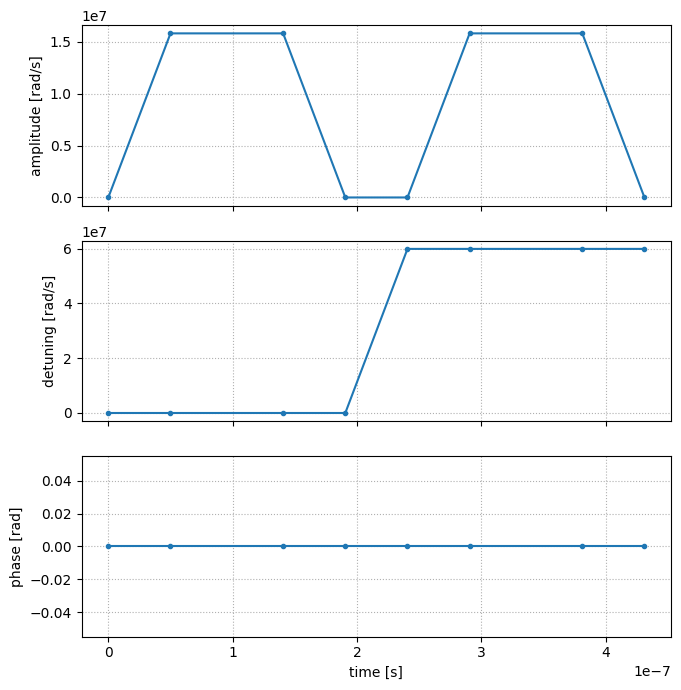

In [4]:
import numpy as np

create_evolve_bell_states(amplitude_area=np.pi / np.sqrt(2), if_show_global_drive=True);

Let us now run the program with the (noiseless) local simulator. In particular, we will sample `n_times=19` points for the evolution of the Bell pair. 

In [5]:
from braket.devices import LocalSimulator

simulator = LocalSimulator("braket_ahs")

In [6]:
%%time
n_times = 19
amplitude_areas = [np.pi / 24 * i for i in range(n_times)]
programs = [
    create_evolve_bell_states(amplitude_area=amplitude_area) for amplitude_area in amplitude_areas
]
results = [simulator.run(program, shots=1000, steps=100).result() for program in programs]
counters = [result.get_counts() for result in results]

CPU times: user 2.62 s, sys: 30.7 ms, total: 2.65 s
Wall time: 2.82 s


To confirm that we indeed have an oscillation between the Bell state $|\phi_1\rangle$ and $|rr\rangle$, let us compare the noiseless simulation result with the expected result.

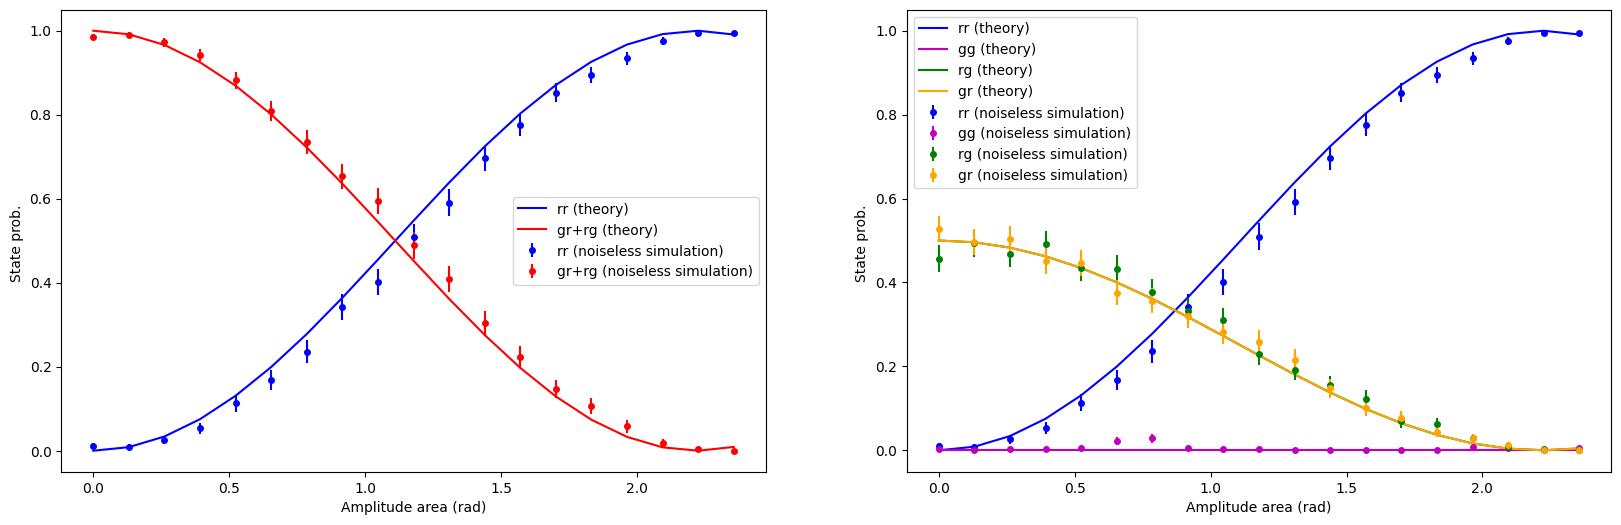

In [7]:
import matplotlib.pyplot as plt


def compare_results(
    counters_list: list[list[dict[str, int]]],
    labels: list[str],
) -> None:
    """Compare a list of labeled simulation results with theory expectation for Bell state evolution

    Args:
        counters_list (list[list[dict[str, int]]]): The list of labeled simulation results
        labels (list[str]): The list of labels

    """
    for counters in counters_list:
        for counter in counters:
            for key in ["rr", "gg", "rg", "gr"]:
                if key not in counter:
                    counter[key] = 0

    _fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    colors = ["b", "m", "g", "orange", "r"]
    markers = ["o", "x"]
    markersize = 4

    axes[0].plot(
        amplitude_areas,
        [np.sin(area / np.sqrt(2)) ** 2 for area in amplitude_areas],
        "-",
        c=colors[0],
        label="rr (theory)",
    )
    axes[0].plot(
        amplitude_areas,
        [np.cos(area / np.sqrt(2)) ** 2 for area in amplitude_areas],
        "-",
        c=colors[-1],
        label="gr+rg (theory)",
    )

    def plot_ax(ax, xs, ys, marker, color, shots, label=""):
        yerr = [2 * np.sqrt(y * (1 - y) / (shots + 1)) for y in ys]
        ax.errorbar(xs, ys, yerr=yerr, fmt=marker, color=color, label=label, markersize=markersize)

    for counters, label, marker in zip(counters_list, labels, markers):
        shots = sum(counters[0].values())
        plot_ax(
            axes[0],
            amplitude_areas,
            [item["rr"] / shots for item in counters],
            marker,
            colors[0],
            shots,
            label=f"rr ({label})",
        )

        plot_ax(
            axes[0],
            amplitude_areas,
            [(item["gr"] + item["rg"]) / shots for item in counters],
            marker,
            colors[-1],
            shots,
            label=f"gr+rg ({label})",
        )

    axes[0].legend()
    axes[0].set_xlabel("Amplitude area (rad)")
    axes[0].set_ylabel("State prob. ")

    axes[1].plot(
        amplitude_areas,
        [np.sin(area / np.sqrt(2)) ** 2 for area in amplitude_areas],
        "-",
        c=colors[0],
        label="rr (theory)",
    )
    axes[1].plot(
        amplitude_areas,
        [0 for _ in amplitude_areas],
        "-",
        c=colors[1],
        label="gg (theory)",
    )
    axes[1].plot(
        amplitude_areas,
        [np.cos(area / np.sqrt(2)) ** 2 / 2 for area in amplitude_areas],
        "-",
        c=colors[2],
        label="rg (theory)",
    )
    axes[1].plot(
        amplitude_areas,
        [np.cos(area / np.sqrt(2)) ** 2 / 2 for area in amplitude_areas],
        "-",
        c=colors[3],
        label="gr (theory)",
    )

    for counters, label, marker in zip(counters_list, labels, markers):
        shots = sum(counters[0].values())
        for state, color in zip(["rr", "gg", "rg", "gr"], colors):
            plot_ax(
                axes[1],
                amplitude_areas,
                [item[state] / shots for item in counters],
                marker,
                color,
                shots,
                label=f"{state} ({label})",
            )

    axes[1].legend(loc="upper left")
    axes[1].set_xlabel("Amplitude area (rad)")
    axes[1].set_ylabel("State prob. ")

    plt.show()


compare_results([counters], ["noiseless simulation"])

In the left panel above, the state probabilities for the Bell state $|\phi_1\rangle$ and the $|rr\rangle$ states are shown to oscillate with respect to the amplitude area, the area of the second trapezoidal waveform of the amplitude in the driving field (see the plot for the driving field shown above). In the right panel, we plot the state probability for the four basis states as a function of the amplitude area.

We note that the discrepancy between the theory and simulation result can be attributed to both the finite ramping time of the amplitude, which is mentioned above, and the blockade approximation where the $|gg\rangle$ state is assumed to have zero probability. This is indeed close to our simulation result, as evident from the right panel, but there is still certain discrepancy which leads to the visible difference in the state probabilities as shown in the left panel. Besides, the error bars shown are calculated as $2\sigma_p \equiv \sqrt{p(1-p)/(N+1)}$ where $p$ is the state probability and $N$ is the number of shots. For example, $2\sigma_p\approx 0.03$ for $p=0.7$ with $1000$ shots. 

## Adding noises to the AHS program

In this section, we will explain how to add various noises to the above noiseless AHS program. First, let us extract the values of different sources of noises for Aquila.

In [8]:
performance = capabilities.performance
pp(performance.dict())

{'lattice': {'atomCaptureProbabilityTypical': Decimal('0.001'),
             'atomCaptureProbabilityWorst': Decimal('0.002'),
             'atomDetectionErrorFalseNegativeTypical': Decimal('0.001'),
             'atomDetectionErrorFalseNegativeWorst': Decimal('0.005'),
             'atomDetectionErrorFalsePositiveTypical': Decimal('0.001'),
             'atomDetectionErrorFalsePositiveWorst': Decimal('0.005'),
             'atomLossProbabilityTypical': Decimal('0.005'),
             'atomLossProbabilityWorst': Decimal('0.01'),
             'atomPositionError': Decimal('2E-7'),
             'fillingErrorTypical': Decimal('0.008'),
             'fillingErrorWorst': Decimal('0.05'),
             'positionErrorAbs': Decimal('2.25E-7'),
             'sitePositionError': Decimal('1E-7'),
             'vacancyErrorTypical': Decimal('0.001'),
             'vacancyErrorWorst': Decimal('0.005')},
 'rydberg': {'rydbergGlobal': {'T1Ensemble': Decimal('0.000075'),
                               'T1

As we can see, the sources of noises are categorized in two fields, where the `'lattice'` field collects the noises associated to the atomic lattice, and the field `'rydberg'` collects the noises related to the global driving field and the measurements. We will give detailed descriptions for these sources of noises, which can also be found via `print(performance.lattice.__doc__)` or `print(performance.rydberg.__doc__)`. The descriptions of these fields can also be found in Braket console. Let us first consider the noises that are associated to initialization of the atomic lattice.

<div class="alert alert-block alert-info">
<b>Note: </b> Certain performance metrics correspond to 4-microsecond AHS programs, and longer programs will experience worse performance. (These are `lattice.positionErrorAbs`, `lattice.atomPositionError`, `lattice.atomLossProbabilityTypical`, `lattice.atomLossProbabilityWorst`, `lattice.atomCaptureProbabilityTypical`, and `lattice.atomCaptureProbabilityWorst`) </a>
</div>


### Adding noises for initializing the atomic lattice

When an AHS program is submitted to Aquila, it will first prepare the atomic lattice as defined in the program. There are several steps in this process, and each step could be affected by different sources of errors. The first step of initializing the atomic lattice is to create a lattice of optical tweezers at the locations specified in the program. However, there is always an uncertainty between the specified positions and the actual positions, as defined in `performance.lattice.sitePositionError`, which is of the order of $10^{-7}$ meters and could depend on the pattern of the atomic lattice. We can assume that the uncertainty follows a normal distribution, and add this noise to the lattice as follows.

In [9]:
def apply_site_position_error(
    sites: list[list[float]],
    site_position_error: float,
) -> list[np.ndarray]:
    """Apply site position error to a list of 2D coordinates

    Args:
        sites (list[list[float]]): A list of 2D coordinates
        site_position_error: The site position error, the systematic and pattern-dependent
            error between specified and actual lattice site positions

    Returns:
        erroneous_sites (list[list[float]]): A list of 2D erroneous coordinates

    """
    erroneous_sites = [site + site_position_error * np.random.normal(size=2) for site in sites]

    return erroneous_sites

We confirm that `apply_site_position_error` indeed yields a list of 2D coordinates with site position noise added

In [10]:
apply_site_position_error([[0, 0]], float(performance.lattice.sitePositionError))

[array([5.93065782e-08, 1.72632074e-07])]

Next, Aquila will put atoms to the sites that are specified as filled and leave others as empty sites. However, there are chances that a site, which is supposed to be empty, is mistakenly filled, and vice versa, and the typical probabilities of these errors are defined as `performance.lattice.vacancyErrorTypical` and  `performance.lattice.fillingErrorTypical` respectively. The corresponding worst-case probabilities are `performance.lattice.vacancyErrorWorst` and  `performance.lattice.fillingErrorWorst`. These filling and vacancy uncertainties can be assumed to follow the binomial distribution, similarly for other uncertainties such as atom detection errors. The latter family of errors refer to either misidentifying an empty site as a filled site (`performance.lattice.atomDetectionErrorFalseNegativeTypical` and `performance.lattice.atomDetectionErrorFalseNegativeWorst`) or misidentifying a filled site as an empty site (`performance.lattice.atomDetectionErrorFalsePositiveTypical` and `performance.lattice.atomDetectionErrorFalsePositiveWorst`) when we make the measurement for the prepared atom array. In order to apply these binomial noises in a unified way, we define the following function.

In [11]:
def apply_binomial_noise(arr: list[int], p01: float, p10: float):
    """Return the noisy array of an otherwise noiseless array subject to a binomial noise

    Args:
        arr (list[int]): An noiseless array
        p01 (float): The probability of mistakenly switching 0 as 1
        p10 (float): The probability of mistakenly switching 1 as 0

    Returns:
        noisy_arr (list[int]): The noisy array

    """
    noisy_arr = []
    for val in arr:
        if val == 1:
            # Apply the error of switching 1 as 0
            noisy_arr.append(1 - np.random.binomial(1, p10))
        else:
            # Apply the error of switching 0 as 1
            noisy_arr.append(np.random.binomial(1, p01))

    return noisy_arr

We can confirm that `apply_binomial_noise` can indeed produce erroreous fillings and pre-sequences that are different from the given fillings as follows

In [12]:
num_trial = 0
while True:
    erroneous_filling = apply_binomial_noise(
        [0, 1],
        float(performance.lattice.fillingErrorTypical),
        float(performance.lattice.vacancyErrorTypical),
    )
    if erroneous_filling != [0, 1]:
        print(f"An erroreous filling is found after {num_trial} trials.")
        break
    else:
        num_trial += 1

num_trial = 0
while True:
    pre_seq = apply_binomial_noise(
        [0, 1],
        float(performance.lattice.atomDetectionErrorFalseNegativeTypical),
        float(performance.lattice.atomDetectionErrorFalsePositiveTypical),
    )
    if pre_seq != [0, 1]:
        print(
            f"A pre sequence is found to be different from the given filling after {num_trial} trials.",
        )
        break
    else:
        num_trial += 1

An erroreous filling is found after 138 trials.
A pre sequence is found to be different from the given filling after 420 trials.


We find that, on average, the `erroneous_filling` is different from the initial filling after 100 trials, which is the order of the filling and vacancy errors. Similarly, a pre-sequence that is different from the given filling will appear approximately after 500 trials.

Finally, we remark that even if all the sites are correctly filled and the atoms are correctly identified, there is still a chance that the atoms are not initialized to the correct atomic state, an error referred to as the ground preparation error `performance.rydberg.groundPrepError`. When this happens, the corresponding filled site is effectively an empty site, although it is marked as filled in the pre-sequence (if there is no atom detection error). To simulate the ground preparation error, we will simply do `apply_binomial_noise(erroneous_filling, 0, float(performance.rydberg.groundPrepError))` where `erroneous_filling` is the erroneous filling caused by the filling and vacancy error. 

We can apply these errors together as the lattice initialization errors

In [13]:
from braket.device_schema.quera.quera_ahs_paradigm_properties_v1 import Performance


def apply_lattice_initialization_errors(
    program: AnalogHamiltonianSimulation,
    performance: Performance,
    typical_error: bool = True,
) -> tuple[list[list[float]], list[int], list[int]]:
    """Apply noises for initializing the atomic lattice

    Args:
        program (AnalogHamiltonianSimulation): An AHS program
        performance (Performance): The parameters determining the limitations of the Rydberg device
        typical_error (bool): If true, apply the typical values for the parameters, otherwise, apply
            the worst-case values for the parameters. Default True.

    Returns:
        erroneous_sites (list[list[float]]): A list of 2D erroneous coordinates
        erroneous_filling (list[int]): A list of erroneous filling
        pre_seq (list[int]): The pre-sequence

    """
    site_position_err = float(performance.lattice.sitePositionError)
    ground_prep_err = float(performance.rydberg.rydbergGlobal.groundPrepError)
    if typical_error:
        filling_err = float(performance.lattice.vacancyErrorTypical)
        vacancy_err = float(performance.lattice.vacancyErrorTypical)
        atom_det_false_positive = float(performance.lattice.atomDetectionErrorFalsePositiveTypical)
        atom_det_false_negative = float(performance.lattice.atomDetectionErrorFalseNegativeTypical)
    else:
        filling_err = float(performance.lattice.vacancyErrorWorst)
        vacancy_err = float(performance.lattice.vacancyErrorWorst)
        atom_det_false_positive = float(performance.lattice.atomDetectionErrorFalsePositiveWorst)
        atom_det_false_negative = float(performance.lattice.atomDetectionErrorFalseNegativeWorst)

    sites = [
        [x, y]
        for (x, y) in zip(program.register.coordinate_list(0), program.register.coordinate_list(1))
    ]
    filling = program.to_ir().setup.ahs_register.filling

    erroneous_sites = apply_site_position_error(sites, site_position_err)
    erroneous_filling = apply_binomial_noise(filling, filling_err, vacancy_err)
    pre_seq = apply_binomial_noise(
        erroneous_filling,
        atom_det_false_negative,
        atom_det_false_positive,
    )

    erroneous_filling = apply_binomial_noise(erroneous_filling, 0, ground_prep_err)

    return erroneous_sites, erroneous_filling, pre_seq

### Adding noises for the global driving field
After the atomic array has been initialized, it follows to apply a global driving field to the atoms as specified in the AHS program. It is inevitable that the actual amplitude and detuning of the driving field would have certain discrepancies compared to the specified values. We first consider the error associated to the global Rabi amplitude applied to the atoms, specifically, those for the slew rate of the amplitude, `performance.rydberg.rydbergGlobal.rabiAmplitudeRampCorrection`, as specified below.

In [14]:
pp(performance.rydberg.rydbergGlobal.rabiAmplitudeRampCorrection)

[RabiCorrection(rampTime=Decimal('5E-8'), rabiCorrection=Decimal('0.92')),
 RabiCorrection(rampTime=Decimal('7.5E-8'), rabiCorrection=Decimal('0.97')),
 RabiCorrection(rampTime=Decimal('1E-7'), rabiCorrection=Decimal('1.0'))]


To understand this source of error, consider two consecutive time-value pairs $(t_1, \Omega_1)$ and $(t_2, \Omega_2)$ in the amplitude of the noiseless AHS program. Because the time series is assumed to be piecewise-linear for the amplitude, the expected amplitude area between these two time points is given by $A=A_1 + A_2$ where $A_1 = \Omega_1 \delta t$ and $A_2 = (\Omega_2-\Omega_1)\delta t/2$ with $\delta t\equiv (t_2-t_1)$. We note that $A_1$ is the amplitude area if the amplitude was kept constant, and $A_2$ is the increased area due to the increased amplitude. 

According to [the description](https://github.com/amazon-braket/amazon-braket-schemas-python/blob/6de44e924e2f359b649a4d320851df5eccc35c66/src/braket/device_schema/quera/quera_ahs_paradigm_properties_v1.py#L308) of `performance.rydberg.rydbergGlobal.rabiAmplitudeRampCorrection`, it suggests that the increased amplitude area $A_2$ would be *smaller* if $\delta t$ is smaller than $10^{-7}$ seconds. To approximate this source of error, we first find the correction factor for the ramp time $\delta t$ via linear interpolation, followed by determining a convex quadratic function to approximate the amplitude time series with smaller area. The found convex quadratic function is applied to the intermediate time points between $t_1$ and $t_2$ in the simulation to emulate the error associate to ramping the global amplitude. 

For amplitude, there is also a relative error for its specified value, `performance.rydberg.rydbergGlobal.rabiFrequencyGlobalErrorRel`. We will apply this source of error on top of the error associated to the ramping of the amplitude.

In [15]:
import scipy


def apply_amplitude_errors(
    amplitude: TimeSeries,
    steps: int,
    rabi_error_rel: float,
    rabi_ramp_correction: list,
    amplitude_max=amplitude_max,
) -> TimeSeries:
    """Apply noises to the amplitude

    Args:
        amplitude (TimeSeries): The time series for the amplitude
        steps (int): The number of time steps in the simulation
        rabi_error_rel (float): The amplitude error as a relative value
        rabi_ramp_correction (list): The dynamic correction to ramped amplitude
            as relative values

    Returns:
        noisy_amplitude (TimeSeries): The time series of the noisy amplitude

    """
    amplitude_times = amplitude.time_series.times()
    amplitude_values = amplitude.time_series.values()

    # Rewrite the rabi_ramp_correction as a function of slopes
    rabi_ramp_correction_slopes = [
        amplitude_max / float(corr.rampTime) for corr in rabi_ramp_correction
    ]
    rabi_ramp_correction_fracs = [float(corr.rabiCorrection) for corr in rabi_ramp_correction]
    rabi_ramp_correction_slopes = rabi_ramp_correction_slopes[::-1]
    rabi_ramp_correction_fracs = rabi_ramp_correction_fracs[::-1]

    # Helper function to find the correction factor for a given slope
    get_frac = scipy.interpolate.interp1d(
        rabi_ramp_correction_slopes,
        rabi_ramp_correction_fracs,
        bounds_error=False,
        fill_value="extrapolate",
    )

    noisy_amplitude_times = np.linspace(0, amplitude_times[-1], steps)
    noisy_amplitude_values = []

    # First apply the rabi ramp correction
    for ind in range(len(amplitude_times)):
        if ind == 0:
            continue

        # First determine the correction factor from the slope
        t1, t2 = amplitude_times[ind - 1], amplitude_times[ind]
        v1, v2 = amplitude_values[ind - 1], amplitude_values[ind]
        slope = (v2 - v1) / (t2 - t1)
        frac = get_frac(np.abs(slope)) * np.sign(slope) if np.abs(slope) > 0 else 1.0

        # Next, determine the coefficients for the quadratic correction
        if frac >= 1.0:
            a, b, c = 0, 0, v2
        else:
            # Determine the coefficients for the quadratic correction
            # of the form f(t) = a*t^2 + b * t + c
            # such that f(t1) = v1 and f(t2) = v2 and
            # a/3*(t2^3-t1^3) + b/2*(t2^2-t1^2) + c(t2-t1) = frac * (t2-t1) * (v2-v1)/2

            a = 3 * (v1 + frac * v1 + v2 - frac * v2) / (t1 - t2) ** 2
            c = (t2 * v1 * ((2 + 3 * frac) * t1 + t2) + t1 * v2 * (t1 + (2 - 3 * frac) * t2)) / (
                t1 - t2
            ) ** 2
            b = (v2 - c - a * t2**2) / t2

        # Finally, put values into noisy_amplitude_values
        for t in noisy_amplitude_times:
            if t1 <= t and t <= t2:
                noisy_amplitude_values.append(a * t**2 + b * t + c)  # noqa: PERF401

    # Next apply amplitude error
    rabi_errors = 1 + rabi_error_rel * np.random.normal(size=len(noisy_amplitude_values))
    noisy_amplitude_values = np.multiply(noisy_amplitude_values, rabi_errors)
    noisy_amplitude_values = [
        max(0, value) for value in noisy_amplitude_values
    ]  # amplitude has to be non-negative

    noisy_amplitude = TimeSeries.from_lists(noisy_amplitude_times, noisy_amplitude_values)

    return noisy_amplitude

Next we consider the errors for the global detuning. Specifically, there are two possbile errors associated to the detuning applied to the atoms, namely the systematic error from the specified global detuning, `performance.rydberg.rydbergGlobal.detuningError`, and the inhomogeneity of the detuning across different atoms, `performance.rydberg.rydbergGlobal.detuningInhomogeneity`. For the latter, we will use a local detuning to emulate the inhomogeneity of the global detuning. Similar to the errors for the amplitude, the errors for the global detuning will also be applied to all the intermediate time points in the simulation independently.

In [16]:
from braket.ahs.field import Field
from braket.ahs.local_detuning import LocalDetuning
from braket.ahs.pattern import Pattern


def apply_detuning_errors(
    detuning: TimeSeries,
    filling: list[int],
    steps: int,
    detuning_error: float,
    detuning_inhomogeneity: float,
) -> tuple[TimeSeries, LocalDetuning]:
    """Apply noises to the detuning

    Args:
        detuning (TimeSeries): The time series for the detuning
        filling (list[int]): The filling of the atom array
        steps (int): The number of time steps in the simulation
        detuning_error (float): The detuning error
        detuning_inhomogeneity (float): The detuning inhomogeneity

    Returns:
        noisy_detuning (TimeSeries): The time series of the noisy detuning
        local_detuning (LocalDetuning): The local detuning used to simulate the detuning inhomogeneity

    """
    detuning_times = detuning.time_series.times()
    detuning_values = detuning.time_series.values()

    noisy_detuning_times = np.linspace(0, detuning_times[-1], steps)
    noisy_detuning_values = np.interp(noisy_detuning_times, detuning_times, detuning_values)

    # Apply the detuning error
    noisy_detuning_values += detuning_error * np.random.normal(size=len(noisy_detuning_values))

    noisy_detuning = TimeSeries.from_lists(noisy_detuning_times, noisy_detuning_values)

    # Apply detuning inhomogeneity
    h = Pattern([np.random.rand() for _ in filling])
    detuning_local = TimeSeries.from_lists(
        noisy_detuning_times,
        detuning_inhomogeneity * np.ones(len(noisy_detuning_times)),
    )

    # Assemble the local detuning
    local_detuning = LocalDetuning(magnitude=Field(time_series=detuning_local, pattern=h))

    return noisy_detuning, local_detuning

We apply the errors for the amplitude and global detuning together as the errors for the global driving field.

In [17]:
def apply_rydberg_noise(
    program: AnalogHamiltonianSimulation,
    performance: Performance,
    steps: int,
):
    """Apply noises to the Rydberg global driving field

    Args:
        program (AnalogHamiltonianSimulation): The given AHS program
        performance (Performance): The parameters determining the limitations of the Rydberg device
        steps (int): The number of time steps in the simulation

    Returns:
        noisy_drive (TimeSeries): The noisy global driving field
        local_detuning (LocalDetuning): The local detuning used to simulate the detuning inhomogeneity

    """
    detuning_error = float(performance.rydberg.rydbergGlobal.detuningError)
    detuning_inhomogeneity = float(performance.rydberg.rydbergGlobal.detuningInhomogeneity)

    noisy_detuning, local_detuning = apply_detuning_errors(
        program.hamiltonian.detuning,
        program.to_ir().setup.ahs_register.filling,
        steps,
        detuning_error,
        detuning_inhomogeneity,
    )

    rabi_error_rel = float(performance.rydberg.rydbergGlobal.rabiFrequencyGlobalErrorRel)
    rabi_ramp_correction = performance.rydberg.rydbergGlobal.rabiAmplitudeRampCorrection
    noisy_amplitude = apply_amplitude_errors(
        program.hamiltonian.amplitude,
        steps,
        rabi_error_rel,
        rabi_ramp_correction,
    )

    noisy_drive = DrivingField(
        amplitude=noisy_amplitude,
        detuning=noisy_detuning,
        phase=program.hamiltonian.phase,
    )

    return noisy_drive, local_detuning

Below we show one example for the erroneous glboal driving field.

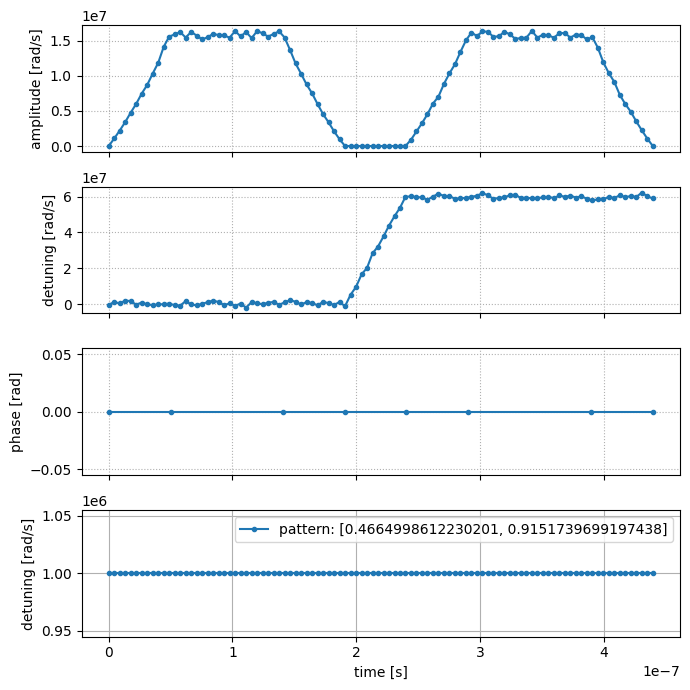

In [18]:
noisy_drive, local_detuning = apply_rydberg_noise(programs[-1], performance, 100)
show_drive_and_local_detuning(noisy_drive, local_detuning)

### Adding the measurement errors

After the global driving field is applied to the atomic array, the final stage of the AHS program is to measure the states of the atoms. During the measurement process, there is a chance an atom in the ground state is misidentified as in the Rydberg state, `performance.rydberg.rydbergGlobal.groundDetectionError`, or an atom in the Rydberg state is misidentified as in the ground state, `performance.rydberg.rydbergGlobal.rydbergDetectionError`. To emulate these source of errors, we can apply the `apply_binomial_noise` function to the given postsequence.


In [19]:
def apply_measurement_errors(postseq: list[int], performance: Performance) -> list[int]:
    """Apply measurement noises

    Args:
        postseq (list[int]): The post sequence before applying the measure noise
        performance (Performance): The parameters determining the limitations of the Rydberg device

    Returns:
        (list[int]): The post sequence after applying the measure noise

    """
    grd_det_error = float(performance.rydberg.rydbergGlobal.groundDetectionError)
    ryd_det_error = float(performance.rydberg.rydbergGlobal.rydbergDetectionError)

    return apply_binomial_noise(postseq, ryd_det_error, grd_det_error)

### Put everything together

With the errors for a) preparing the atomic array, b) applying the global field, and c) measuring the final states of the atoms explained, we are ready to assemble them together to perform noisy simulation for a given AHS program. We emphasize that each shot of the noisy simulation is simulated independently with a different AHS program that differs slightly from the given AHS program, due to the random fluctuation of the parameters. Despite the noisy simulation being more expensive compared to the noiseless simulation, it emulates the actual experiment on the QPU, where each shot of the experiment experiences a different instance of the uncontrolled environmental factors.

In [20]:
from braket.ahs.atom_arrangement import SiteType
from braket.task_result.analog_hamiltonian_simulation_task_result_v1 import (
    AnalogHamiltonianSimulationShotMeasurement,
    AnalogHamiltonianSimulationShotMetadata,
    AnalogHamiltonianSimulationShotResult,
    AnalogHamiltonianSimulationTaskResult,
)
from braket.task_result.task_metadata_v1 import TaskMetadata
from braket.tasks.analog_hamiltonian_simulation_quantum_task_result import (
    AnalogHamiltonianSimulationQuantumTaskResult,
)


def ahs_noise_simulation(
    program: AnalogHamiltonianSimulation,
    performance: Performance,
    shots: int = 1000,
    steps: int = 100,
) -> AnalogHamiltonianSimulationQuantumTaskResult:
    """Noisy simulation for an AHS program

    Args:
        program (AnalogHamiltonianSimulation): The given noiseless AHS program
        performance (Performance): The parameters determining the limitations of the Rydberg device
        shots (int): The number of shots for the program
        steps (int): The number of time steps in the simulation

    Returns:
        (AnalogHamiltonianSimulationQuantumTaskResult): The noisy simulation result of the AHS program

    """
    measurements = []
    for _ in range(shots):
        sites, fillings, preseq = apply_lattice_initialization_errors(program, performance)
        drive, local_detuning = apply_rydberg_noise(program, performance, steps)

        # Assemble the noisy program
        register = AtomArrangement()
        for site, filling in zip(sites, fillings):
            if filling == 1:
                register.add(site)
            else:
                register.add(site, site_type=SiteType.VACANT)

        noisy_program = AnalogHamiltonianSimulation(
            register=register,
            hamiltonian=drive + local_detuning,
        )

        result = simulator.run(noisy_program, shots=1, steps=steps).result()

        postseq = result.measurements[0].post_sequence

        new_postseq = apply_measurement_errors(postseq, performance)

        shot_measurement = AnalogHamiltonianSimulationShotMeasurement(
            shotMetadata=AnalogHamiltonianSimulationShotMetadata(shotStatus="Success"),
            shotResult=AnalogHamiltonianSimulationShotResult(
                preSequence=preseq,
                postSequence=new_postseq,
            ),
        )

        measurements.append(shot_measurement)

    task_metadata = TaskMetadata(
        id="rydberg",
        shots=shots,
        deviceId="rydbergLocalSimulator",
    )

    ahs_task_result = AnalogHamiltonianSimulationTaskResult(
        taskMetadata=task_metadata,
        measurements=measurements,
    )

    return AnalogHamiltonianSimulationQuantumTaskResult.from_object(ahs_task_result)

Let us proceed to rerun the AHS program for creating and evolving a Bell state, with various sources of errors included. 

In [21]:
%%time
noisy_results = [
    ahs_noise_simulation(program, performance, shots=100, steps=100) for program in programs
]

CPU times: user 4min 8s, sys: 1.93 s, total: 4min 10s
Wall time: 4min 33s


Let us compare the noisy simulation result with the expected result.

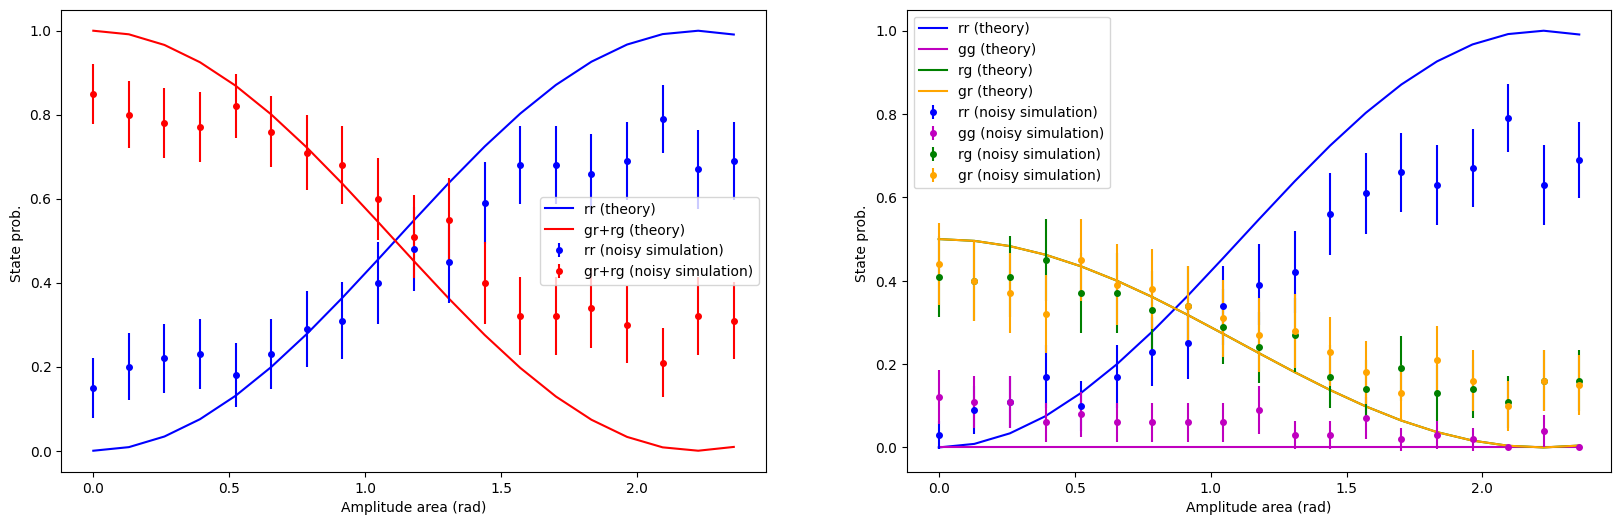

In [22]:
noisy_counters = [result.get_counts() for result in noisy_results]
compare_results([noisy_counters], ["noisy simulation"])

From the left panel above, the noises not only affect the preparation of the Bell state $|\phi_1\rangle$ but also its evolution as we increase the amplitude area. Despite that, the oscillation of Bell state is still visible in the noisy setting. From the right panel, we see that the probability of the $|rr\rangle$ is significantly affected by the noises. As we will see below, this can be primarily attributed to the noises associated to the atom position fluctuations.

## Compare to QPU

Let us rerun the *noiseless* AHS program on the QPU, and compare its result from the result obtained from the noisy simulation.

In [23]:
task_arns = []
for amplitude_area in amplitude_areas:
    program = create_evolve_bell_states(
        amplitude_area=amplitude_area,
        if_parallel=True,
    )

    task = qpu.run(program.discretize(qpu), shots=100)

    metadata = task.metadata()
    task_arn = metadata["quantumTaskArn"]
    print(task_arn)
    task_arns.append(task_arn)

with open("task_arns.npy", "wb") as f:
    np.save(f, np.array(task_arns))

In [24]:
from braket.aws import AwsQuantumTask

with open("task_arns.npy", "rb") as f:
    task_arns = np.load(f, allow_pickle=True)

qpu_results = [AwsQuantumTask(arn=task_arn).result() for task_arn in task_arns]
qpu_counters = [result.get_counts() for result in qpu_results]

For efficiently making use of the full area allowed by the QPU, we have executed several copies of identical experiments in parallel. Below, we first aggregate the QPU results, followed by comparing to noisy simulation results.

In [25]:
def aggregate_qpu_counters(counters_qpu: dict[str, int]) -> dict[str, int]:
    """Aggregate the results from QPU

    Args:
        counters_qpu (dict[str, int]): Native results from the QPU

    Returns:
        (dict[str, int]): Aggregated result from the QPU

    Example:
        >>> aggregate_qpu_counters({"grggrgrr": 10, "gggrrggg": 2})
        >>> {'gg': 14, 'gr': 12, 'rg': 12, 'rr': 10}

    """
    states = ["gg", "gr", "rg", "rr"]
    counters = dict.fromkeys(states, 0)
    for key, val in counters_qpu.items():
        for i in range(int(len(key) / 2)):
            state = key[2 * i : 2 * i + 2]
            if state in counters:
                counters[state] += val

    return counters


qpu_counters = [aggregate_qpu_counters(item) for item in qpu_counters]

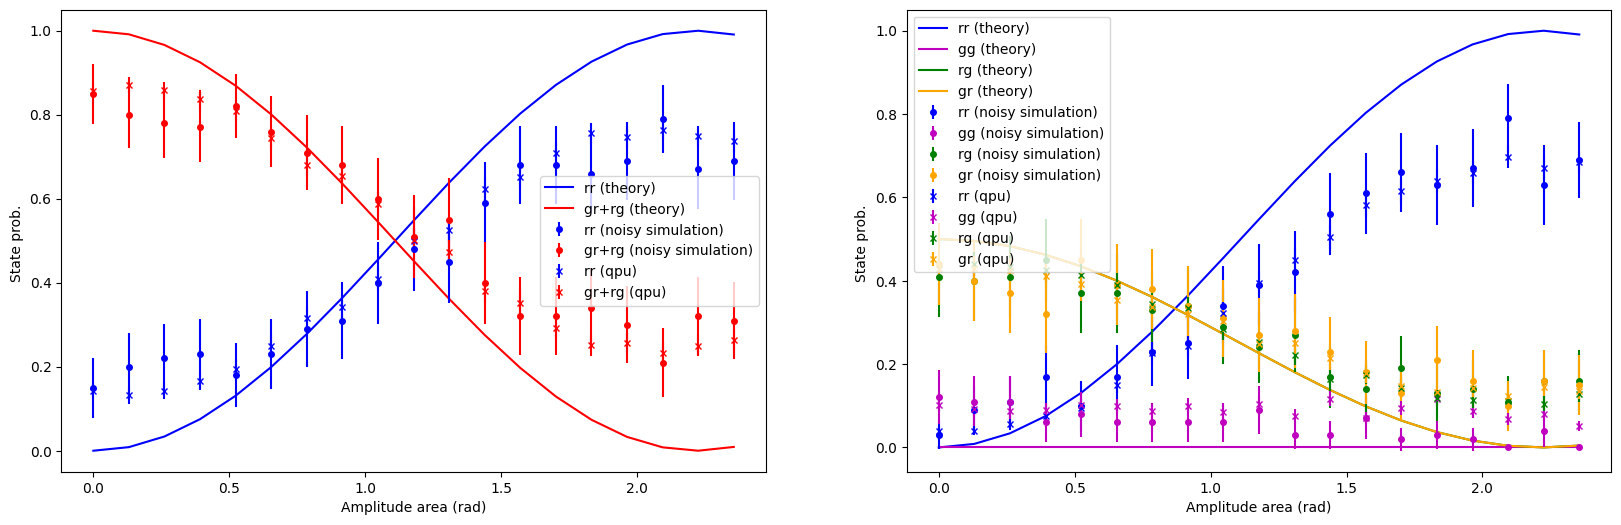

In [26]:
compare_results([noisy_counters, qpu_counters], ["noisy simulation", "qpu"])

We see that the result obtained from QuEra's Aquila agree with that obtained from the noisy simulation.

# Noisy simulation with customized performance

Although we find that the result from the noisy simulation agrees well with those obtained from the QPU, it is unclear which sources of error contribute the most to the discrepancies between the theory result and the experimental result. It is possible to customize the noise model to explore the effects of various sources of error in more details. For that, we start by defining a function which allows one to modify the given noise model in various ways.

In [27]:
from copy import deepcopy
from decimal import Decimal
from typing import Union

from braket.device_schema.quera.quera_ahs_paradigm_properties_v1 import RabiCorrection


def customize_performance_for_field(
    performance: Performance,
    name: str,
    value: Union[float, list[tuple[float, float]]],
    modification_type: str = "replace",
) -> Performance:
    """Customize a field in the given noise model

    Args:
        performance (Performance): The given noise model
        name (str): The name of the field to be modified
        value (Union[float, list[tuple[float, float]]]): The updated values for the modified field
        modification_type (str): The behavior of the customization.
            If set to "replace", the value of the corresponding field will be updated
            If set to "keep_only", the value of the corresponding field will be updated, and
                all other fields in the noise models will be set to zero.

    Returns:
        (Performance): The updated noise model

    """
    performance = deepcopy(performance)

    def modify_dict(mydict):
        found_key = (
            False  # If False, the `name` is not a valid field in the noise model; otherwise True
        )
        for key, val in mydict.items():
            if key == name:
                found_key = True  # `name` is found in the noise model
                if isinstance(val, Decimal):
                    mydict[key] = Decimal(str(value))
                elif isinstance(val, list):
                    # Assuming the every list in the performance model is of type `RabiCorrection`
                    mydict[key] = [
                        RabiCorrection(rampTime=Decimal(str(t)), rabiCorrection=Decimal(str(v)))
                        for (t, v) in value
                    ]
                if modification_type == "replace":
                    return found_key
            elif isinstance(val, Decimal):
                if modification_type == "keep-only":
                    mydict[key] = Decimal("0.0")
            elif isinstance(val, list):
                if modification_type == "keep-only":
                    mydict[key] = [
                        RabiCorrection(rampTime=corr.rampTime, rabiCorrection=Decimal("0.999"))
                        for corr in mydict[key]
                    ]
            else:
                found_key = found_key or modify_dict(val.__dict__)

        return found_key

    found_key = modify_dict(performance.__dict__)

    if found_key is False:
        raise KeyError(f"{name} is not a valid field for the noise model")

    return performance

Let us now consider a noise model with only the measurement errors, namely the rydberg and ground state detection errors.

In [28]:
performance_spam = customize_performance_for_field(
    performance,
    "groundDetectionError",
    performance.rydberg.rydbergGlobal.groundDetectionError,
    modification_type="keep-only",
)

performance_spam = customize_performance_for_field(
    performance_spam,
    "rydbergDetectionError",
    performance.rydberg.rydbergGlobal.rydbergDetectionError,
    modification_type="replace",
)

pp(performance_spam)

{'lattice': {'atomCaptureProbabilityTypical': Decimal('0.0'),
             'atomCaptureProbabilityWorst': Decimal('0.0'),
             'atomDetectionErrorFalseNegativeTypical': Decimal('0.0'),
             'atomDetectionErrorFalseNegativeWorst': Decimal('0.0'),
             'atomDetectionErrorFalsePositiveTypical': Decimal('0.0'),
             'atomDetectionErrorFalsePositiveWorst': Decimal('0.0'),
             'atomLossProbabilityTypical': Decimal('0.0'),
             'atomLossProbabilityWorst': Decimal('0.0'),
             'atomPositionError': Decimal('0.0'),
             'fillingErrorTypical': Decimal('0.0'),
             'fillingErrorWorst': Decimal('0.0'),
             'positionErrorAbs': Decimal('0.0'),
             'sitePositionError': Decimal('0.0'),
             'vacancyErrorTypical': Decimal('0.0'),
             'vacancyErrorWorst': Decimal('0.0')},
 'rydberg': {'rydbergGlobal': {'T1Ensemble': Decimal('0.0'),
                               'T1Single': Decimal('0.0'),
        

We confirmed that `performance_spam` has only two sources of error, namely those for measurement errors. Let us now rerun the noisy simulation and compare to the result obtained from the QPU.

In [29]:
%%time
noisy_results_spam = [
    ahs_noise_simulation(program, performance_spam, shots=100, steps=100) for program in programs
]

CPU times: user 4min, sys: 1.96 s, total: 4min 2s
Wall time: 4min 7s


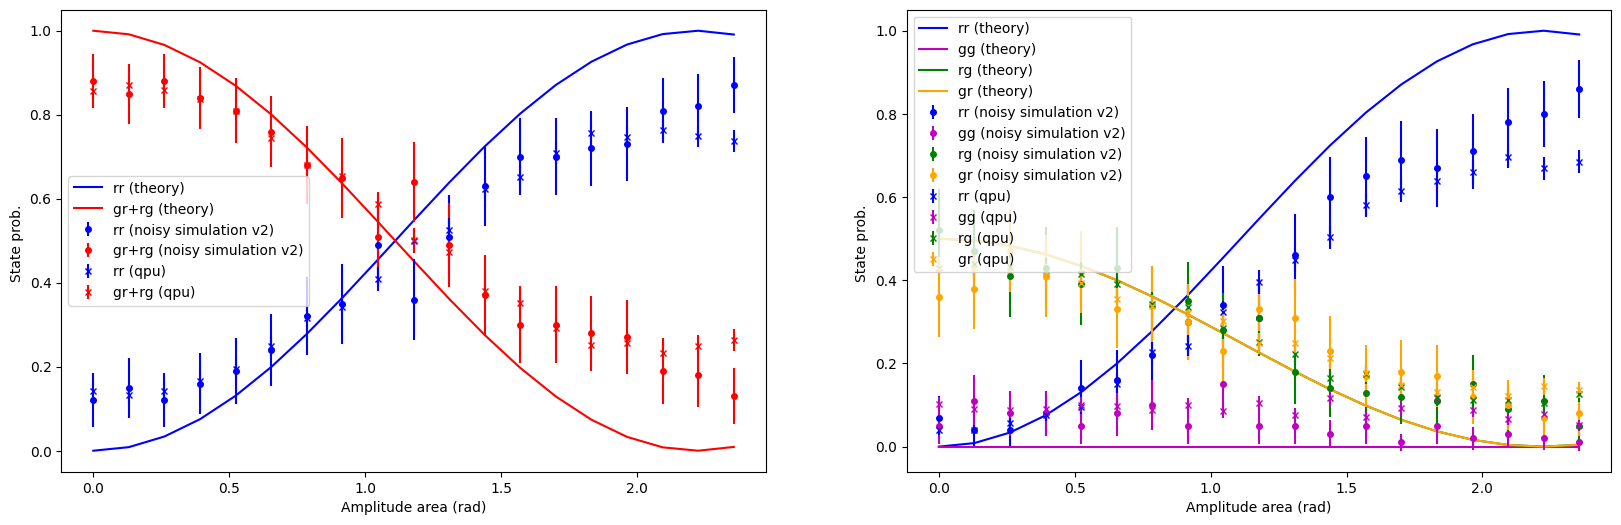

In [30]:
noisy_counters_spam = [result.get_counts() for result in noisy_results_spam]
compare_results([noisy_counters_spam, qpu_counters], ["noisy simulation v2", "qpu"])

We see that the noise model with only measurement errors produce results that agree qualitatitvely well with that obtained from the QPU, within the error bars.


# Summary

In summary, in this notebook, we introduce how to apply various sources of noise to AHS programs. We illustrate with a toy example that the noisy simulation results agree qualitatitvely well with that obtained from the QPU. Hence, we provide a way to understand how the noises in the device could affect a given AHS program of interest.

Let us remark on several sources of noises that have been omitted in this notebook.

1. We omitted `lattice.atomCaptureProbabilityTypical` and `lattice.atomLossProbabilityTypical`, which describe the probability of losing or capturing atoms during the quantum evolutions, and `lattice.atomPositionError` and `lattice.positionErrorAbs`, which are related to the thermal atom position errors. These errors have different characteristics compared to those discussed above, which cannot be specified in the AHS program, and hence cannot be emulated using the approach discribed above. In order to simulate these sources of errors, one would need to include the uncontrolled dynamical degrees of freedom, and keep track of their entanglement with the system of interest.

2. We did not discuss $T_1$ or $T_2$ for Aquila explicitly, but these performance metrics can be extracted partially from the noise sources discussed above, including amplitude noise, detuning noise and atom position error. One could benchmark the effects of different noise sources to the coherence times using customized noise models as illustrated above.

3. We omitted `rydberg.rydbergGlobal.rabiFrequencyInhomogeneityRel` and `rydberg.rydbergGlobal.rabiFrequencyErrorRel` are related to the inhomogeneity of the global amplitude, which cannot be simulated because the AHS local simulator does not support local amplitude yet. However, it is possible implement the "LocalAmplitude" feature for the AHS local simulator, which will be left as a future work.

4. We have also omitted the source of errors related to local detuning will be discussed further in the future. 


In [26]:
print("Quantum Task Summary")
print(tracker.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
)
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD",
)

Quantum Task Summary
{'arn:aws:braket:us-east-1::device/qpu/quera/Aquila': {'shots': 1900, 'tasks': {'QUEUED': 19}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 24.70 USD
